In [27]:
import pandas as pd
import numpy as np
import pdfplumber
from pdfplumber.utils import within_bbox, collate_chars
from operator import itemgetter
import datetime
import sys, os
import matplotlib.pyplot as plt

Functions to convert NICS PDF to DataFarme/CSV

In [3]:
COLUMNS = [
    "month",
    "state",
    "permit",
    "permit_recheck",
    "handgun",
    "long_gun",
    "other",
    "multiple",
    "admin",
    "prepawn_handgun",
    "prepawn_long_gun",
    "prepawn_other",
    "redemption_handgun",
    "redemption_long_gun",
    "redemption_other",
    "returned_handgun",
    "returned_long_gun",
    "returned_other",
    "rentals_handgun",
    "rentals_long_gun",
    "private_sale_handgun",
    "private_sale_long_gun",
    "private_sale_other",
    "return_to_seller_handgun",
    "return_to_seller_long_gun",
    "return_to_seller_other",
    "totals"
]

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

def parse_month(month_str):
    d = datetime.datetime.strptime(month_str, "%B - %Y")
    return d.strftime("%Y-%m")

def parse_value(x):
    #if it's null or nothing leave it alone
    if pd.isnull(x) or x == "": return None
    #if it has a comma strip it out and return as an int
    return int(x.replace(",", ""))

def chk_data(checks):
    try:
        assert(len(checks) > 0)
    except:
        raise Exception("No data found.")

    ## Test vertical totals
    # [2:] because first two columns are month and state name
    for c in COLUMNS[2:]:
        # -1 so as not to include the totals column on the end
        v_total = checks[c].iloc[-1]
        v_colsum = checks[c].sum()
        try:
            assert(v_colsum == (v_total * 2))
        except:
            raise Exception("Vertical totals don't match on {0}.".format(c))

    ## Test horizontal totals
    h_colsums = checks.fillna(0).sum(axis=1)
    h_totals = checks["totals"].fillna(0)
    zipped = zip(checks["state"], h_colsums, h_totals)
    for state, h_colsum, h_total in zipped:
        try:
            assert(h_colsum == (h_total * 2))
        except:
            raise Exception("Horizontal totals don't match on {0}.".format(state))
            
def parse_pdf_page(page):
    #crop the top to get the month and year
    month_crop = page.within_bbox((0, 35, page.width, 65))
    month_text = month_crop.extract_text(x_tolerance=2)
    month = parse_month(month_text)
    
    #crop out the table itself
    table_crop = page.crop((0, 80, page.width, 485))

    _table = table_crop.extract_table({
        "horizontal_strategy": "text",
        "explicit_vertical_lines": [
            min(map(itemgetter("x0"), table_crop.chars))
        ],
        "intersection_tolerance": 5
    })

    table = pd.DataFrame([ [ month ] + row for row in _table ])
    
    #rename the columns
    table.columns = COLUMNS
    #get rid of commas and turn values back into int's
    table[table.columns[2:]] = table[table.columns[2:]].applymap(parse_value)
    
    #fix the illinois state name in some of the pdf's pages
    table.loc[(table["state"] == "llinois"), "state"] = "Illinois"
    try: chk_data(table)
    except: raise Exception("Invalid data for " + month)

    return table

def parse_pdf(file_obj):
    pdf = pdfplumber.load(file_obj)
    #parse pdf one page at a time and concatenates into single dataframe
    checks = pd.concat(list(map(parse_pdf_page, pdf.pages))).reset_index(drop=True)

    return checks[checks["state"] != "Totals"]


open's nics pdf and parses out useable data and creates csv file

In [ ]:
#this takes ~15 minutes to run
pdf_file = "./raw_data/NICS.pdf"
file = open(pdf_file, 'rb')
data_df = parse_pdf(file)
data_df["year"] = data_df['month'].str.split("-").str[0]
data_df["mon_num"] = data_df['month'].str.split("-").str[1]
final_df = data_df.loc[(data_df["state"] != "Guam") & (data_df["state"] != "District of Columbia") & (data_df["state"] != "Mariana Islands") & (data_df["state"] != "Virgin Islands") & (data_df["state"] != "Puerto Rico")]
sa = []
for n,v in final_df["state"].iteritems():
    sa.append(us_state_abbrev[v])
    
final_df["state_abbr"] = pd.Series(sa)
final_df.to_csv("./output_csv/Guns_output.csv", index=False)
final_df.head()


read in just created csv and total up various columns and group to year level for years 2004 - 2017

In [4]:
main_df = pd.read_csv("./output_csv/Guns_output.csv")
a_gp = main_df.groupby("year")
yearly_df = pd.DataFrame({"all_permit":a_gp["permit"].sum(),
                          "all_permit_recheck":a_gp["permit_recheck"].sum(),
                          "all_multiple":a_gp["multiple"].sum(),
                          "all_admin":a_gp["admin"].sum(),
                          "total_handgun":a_gp["handgun"].sum()+a_gp["prepawn_handgun"].sum()+a_gp["redemption_handgun"].sum()+a_gp["returned_handgun"].sum()+a_gp["rentals_handgun"].sum()+a_gp["private_sale_handgun"].sum()+a_gp["return_to_seller_handgun"].sum(),
                          "total_long_gun":a_gp["long_gun"].sum()+a_gp["prepawn_long_gun"].sum()+a_gp["redemption_long_gun"].sum()+a_gp["returned_long_gun"].sum()+a_gp["rentals_long_gun"].sum()+a_gp["private_sale_long_gun"].sum()+a_gp["return_to_seller_long_gun"].sum(),
                          "total_other":a_gp["other"].sum()+a_gp["prepawn_other"].sum()+a_gp["redemption_other"].sum()+a_gp["returned_other"].sum()+a_gp["private_sale_other"].sum()+a_gp["return_to_seller_other"].sum(),
                          "all_total_bckgnd_chk":a_gp["totals"].sum()})
year_df = yearly_df.reset_index(level="year")
ye_df = year_df.drop([0,1,2,3,4,5,20,21])
ye_df.to_csv("./output_csv/yearly_bkgnd_chk.csv",index=False)
g_df = pd.read_csv("./output_csv/yearly_bkgnd_chk.csv")
g_df

,year,all_permit,all_permit_recheck,all_multiple,all_admin,total_handgun,total_long_gun,total_other,all_total_bckgnd_chk
0,2004,1345672.0,0.0,101737,51559.0,2170546.0,4902212.0,0.0,8571726
1,2005,1350193.0,0.0,109549,13158.0,2420438.0,4964261.0,0.0,8857599
2,2006,2036569.0,0.0,129897,41792.0,2624036.0,5150461.0,0.0,9982755
3,2007,3077655.0,0.0,324191,27318.0,2812330.0,4910504.0,0.0,11151998
4,2008,3697854.0,0.0,186889,13883.0,3526870.0,5258744.0,0.0,12684240
5,2009,4449333.0,0.0,235469,7291.0,3907772.0,5351294.0,23164.0,13974323
6,2010,4882948.0,0.0,180396,6723.0,3934424.0,5252266.0,53169.0,14309926
7,2011,5544418.0,0.0,219353,11903.0,4592538.0,5884286.0,70541.0,16323039
8,2012,5683545.0,0.0,229924,6670.0,6021948.0,7341010.0,163407.0,19446504
9,2013,6168970.0,0.0,240999,5663.0,6734730.0,7582862.0,213537.0,20946761


prepare population data read in and convert values in first csv

In [5]:
pop1 = "./raw_data/populations_new.csv"
pop1_df = pd.read_csv(pop1)
p_df = pop1_df.rename(columns = {"Unnamed: 0":"state","Unnamed: 1":"1999"})
pp_df = p_df.drop([0])
pp_df[pp_df.columns[1:-1]] = pp_df[pp_df.columns[1:-1]].applymap(parse_value)
pp_df.head()

,state,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,state abrv
1,Alabama,4447207,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,4718206,4757938,AL
2,Alaska,626933,627963,633714,642337,648414,659286,666946,675302,680300,687455,698895,AK
3,Arizona,5130247,5160586,5273477,5396255,5510364,5652404,5839077,6029141,6167681,6280362,6343154,AZ
4,Arkansas,2673293,2678588,2691571,2705927,2724816,2749686,2781097,2821761,2848650,2874554,2896843,AR
5,California,33871653,33987977,34479458,34871843,35253159,35574576,35827943,36021202,36250311,36604337,36961229,CA


read in and convert values in second csv

In [6]:
pop2 = "./raw_data/pop2_new.csv"
pop2_df = pd.read_csv(pop2)
p2_df = pop2_df.rename(columns={"Unnamed: 0":"state"})
pp2_df = p2_df.drop(columns=["state","Census","Estimates Base"])
ppp2_df = pp2_df.drop([0])
ppp2_df[ppp2_df.columns[:-1]] = ppp2_df[ppp2_df.columns[:-1]].applymap(parse_value)
ppp2_df.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,State abrv
1,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871,AL
2,713906,722038,730399,737045,736307,737547,741504,739786,737438,AK
3,6407774,6473497,6556629,6634999,6733840,6833596,6945452,7048876,7171646,AZ
4,2921978,2940407,2952109,2959549,2967726,2978407,2990410,3002997,3013825,AR
5,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045,CA


merge the two dataframes and drop the extra state abrv column

In [7]:
pop_merge_df = pp_df.merge(ppp2_df, left_on="state abrv",right_on="State abrv")
p_merge_df = pop_merge_df.drop(columns=["state abrv"])
p_merge_df.head()

,state,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,State abrv
0,Alabama,4447207,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,...,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871,AL
1,Alaska,626933,627963,633714,642337,648414,659286,666946,675302,680300,...,713906,722038,730399,737045,736307,737547,741504,739786,737438,AK
2,Arizona,5130247,5160586,5273477,5396255,5510364,5652404,5839077,6029141,6167681,...,6407774,6473497,6556629,6634999,6733840,6833596,6945452,7048876,7171646,AZ
3,Arkansas,2673293,2678588,2691571,2705927,2724816,2749686,2781097,2821761,2848650,...,2921978,2940407,2952109,2959549,2967726,2978407,2990410,3002997,3013825,AR
4,California,33871653,33987977,34479458,34871843,35253159,35574576,35827943,36021202,36250311,...,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045,CA


total population data and add totals to main df

In [8]:
data = []
for n in p_merge_df.columns[1:-1]:
    if((int(n) >= 2004)&(int(n) <= 2017)):
        data.append(p_merge_df[n].sum())
g_df["US_POP"] = data
g_df.to_csv("./output_csv/yearly_bkgnd_w_pop_data.csv")
g_df

,year,all_permit,all_permit_recheck,all_multiple,all_admin,total_handgun,total_long_gun,total_other,all_total_bckgnd_chk,US_POP
0,2004,1345672.0,0.0,101737,51559.0,2170546.0,4902212.0,0.0,8571726,292237544
1,2005,1350193.0,0.0,109549,13158.0,2420438.0,4964261.0,0.0,8857599,294949463
2,2006,2036569.0,0.0,129897,41792.0,2624036.0,5150461.0,0.0,9982755,297809231
3,2007,3077655.0,0.0,324191,27318.0,2812330.0,4910504.0,0.0,11151998,300656803
4,2008,3697854.0,0.0,186889,13883.0,3526870.0,5258744.0,0.0,12684240,303513730
5,2009,4449333.0,0.0,235469,7291.0,3907772.0,5351294.0,23164.0,13974323,306179301
6,2010,4882948.0,0.0,180396,6723.0,3934424.0,5252266.0,53169.0,14309926,308721000
7,2011,5544418.0,0.0,219353,11903.0,4592538.0,5884286.0,70541.0,16323039,310960407
8,2012,5683545.0,0.0,229924,6670.0,6021948.0,7341010.0,163407.0,19446504,313239493
9,2013,6168970.0,0.0,240999,5663.0,6734730.0,7582862.0,213537.0,20946761,315407296


pull in ATF gun manufacturing data total and add to main DF

In [10]:
# ATF gun manufactuing/ import-export data. 
guns_made = pd.read_csv("./raw_data/firearms_made.txt",sep="\s+")
guns_made["handguns"] = guns_made["Pistols"] + guns_made["Revolvers"]
guns_made["long_guns"] = guns_made["Rifles"] + guns_made["Shotguns"]
guns_export = pd.read_csv("./raw_data/firearms_export.txt",sep="\s+")
guns_export["handguns"] = guns_export["Pistols"] + guns_export["Revolvers"]
guns_export["long_guns"] = guns_export["Rifles"] + guns_export["Shotguns"]
guns_import = pd.read_csv("./raw_data/firearms_import.txt",sep="\s+")
guns_import["long_guns"] = guns_import["Rifles"] + guns_import["Shotguns"]
guns_total = pd.DataFrame({"year":guns_made["Year"],
                           "total_long_guns_us":(guns_made["long_guns"]-guns_export["long_guns"])+guns_import["long_guns"],
                           "total_handguns_us":(guns_made["handguns"]-guns_export["handguns"])+guns_import["Handguns"],
                           "total_other_us":guns_made["Misc"]-guns_export["Misc"]})
g_df["total_long_guns_us"] = guns_total["total_long_guns_us"]
g_df["total_handguns_us"] = guns_total["total_handguns_us"]
g_df["total_other_us"] = guns_total["total_other_us"]
g_df["total_guns_produced"] = guns_total["total_long_guns_us"]+guns_total["total_handguns_us"]+guns_total["total_other_us"]
g_df.to_csv("./output_csv/yearly_data_pop_and_manufact.csv")
g_df

,year,all_permit,all_permit_recheck,all_multiple,all_admin,total_handgun,total_long_gun,total_other,all_total_bckgnd_chk,US_POP,total_long_guns_us,total_handguns_us,total_other_us,total_guns_produced
0,2004,1345672.0,0.0,101737,51559.0,2170546.0,4902212.0,0.0,8571726,292237544,3035482,1822385,12097,4869964
1,2005,1350193.0,0.0,109549,13158.0,2420438.0,4964261.0,0.0,8857599,294949463,3230961,1907335,15191,5153487
2,2006,2036569.0,0.0,129897,41792.0,2624036.0,5150461.0,0.0,9982755,297809231,3316736,2399739,1850,5718325
3,2007,3077655.0,0.0,324191,27318.0,2812330.0,4910504.0,0.0,11151998,300656803,3506144,2917743,37937,6461824
4,2008,3697854.0,0.0,186889,13883.0,3526870.0,5258744.0,0.0,12684240,303513730,3357840,3426961,92041,6876842
5,2009,4449333.0,0.0,235469,7291.0,3907772.0,5351294.0,23164.0,13974323,306179301,4326712,4511091,130377,8968180
6,2010,4882948.0,0.0,180396,6723.0,3934424.0,5252266.0,53169.0,14309926,308721000,3511417,4494635,51158,8057210
7,2011,5544418.0,0.0,219353,11903.0,4592538.0,5884286.0,70541.0,16323039,310960407,4573483,4752010,171909,9497402
8,2012,5683545.0,0.0,229924,6670.0,6021948.0,7341010.0,163407.0,19446504,313239493,6210392,6634485,290769,13135646
9,2013,6168970.0,0.0,240999,5663.0,6734730.0,7582862.0,213537.0,20946761,315407296,7445169,8073647,472394,15991210


adding hunting permit data

In [25]:
hunt_df = pd.read_csv("./raw_data/hunting_permits_issued.csv")
hunt_df[hunt_df.columns[1:]] = hunt_df[hunt_df.columns[1:]].applymap(parse_value)
permit_df = pd.read_csv("./raw_data/licenses_per_state.csv")
hunt_per_df = permit_df.drop([14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43])
hunt_per_df[hunt_per_df.columns[1:]] = hunt_per_df[hunt_per_df.columns[1:]].applymap(parse_value)
g_df["hunt_permit_issued"] = hunt_df["Total"]
g_df["total_hunt_licences"] = hunt_per_df["Total"]
g_df.to_csv("./output_csv/final_dataframe.csv")
g_df

,year,all_permit,all_permit_recheck,all_multiple,all_admin,total_handgun,total_long_gun,total_other,all_total_bckgnd_chk,US_POP,total_long_guns_us,total_handguns_us,total_other_us,total_guns_produced,hunt_permit_issued,total_hunt_licences
0,2004,1345672.0,0.0,101737,51559.0,2170546.0,4902212.0,0.0,8571726,292237544,3035482,1822385,12097,4869964,34187932,14966406
1,2005,1350193.0,0.0,109549,13158.0,2420438.0,4964261.0,0.0,8857599,294949463,3230961,1907335,15191,5153487,34673422,14679041
2,2006,2036569.0,0.0,129897,41792.0,2624036.0,5150461.0,0.0,9982755,297809231,3316736,2399739,1850,5718325,36131597,14726427
3,2007,3077655.0,0.0,324191,27318.0,2812330.0,4910504.0,0.0,11151998,300656803,3506144,2917743,37937,6461824,35609605,14575484
4,2008,3697854.0,0.0,186889,13883.0,3526870.0,5258744.0,0.0,12684240,303513730,3357840,3426961,92041,6876842,35181199,14623598
5,2009,4449333.0,0.0,235469,7291.0,3907772.0,5351294.0,23164.0,13974323,306179301,4326712,4511091,130377,8968180,35273464,14452464
6,2010,4882948.0,0.0,180396,6723.0,3934424.0,5252266.0,53169.0,14309926,308721000,3511417,4494635,51158,8057210,34080581,14447187
7,2011,5544418.0,0.0,219353,11903.0,4592538.0,5884286.0,70541.0,16323039,310960407,4573483,4752010,171909,9497402,34653719,14973528
8,2012,5683545.0,0.0,229924,6670.0,6021948.0,7341010.0,163407.0,19446504,313239493,6210392,6634485,290769,13135646,35698886,14956278
9,2013,6168970.0,0.0,240999,5663.0,6734730.0,7582862.0,213537.0,20946761,315407296,7445169,8073647,472394,15991210,36386439,14629726


## Visualizing Data

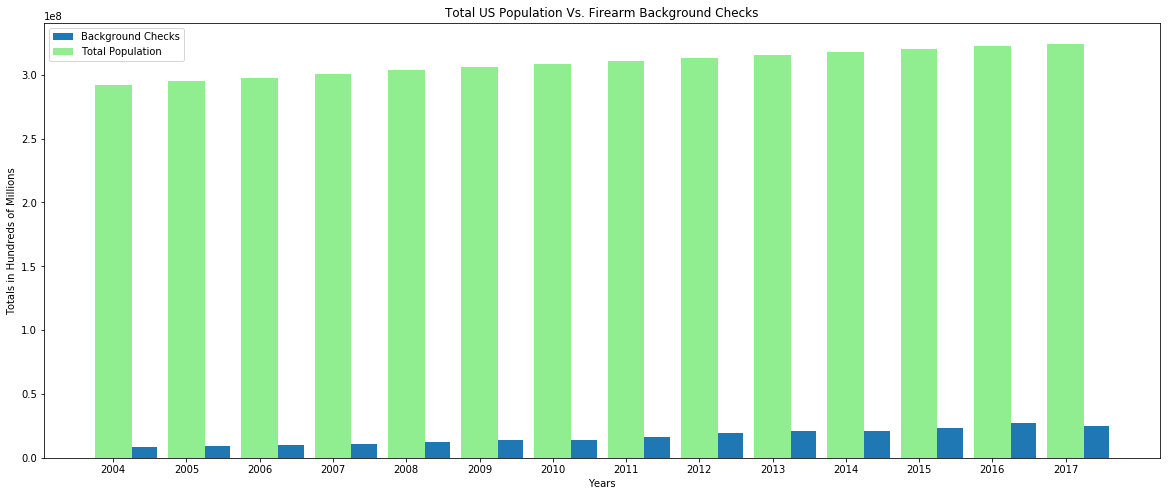

In [80]:
y_pos = np.arange(len(g_df["year"]))
plt.bar(y_pos+0.2,g_df["all_total_bckgnd_chk"],label="Background Checks")
plt.bar(y_pos,g_df["US_POP"],width=0.5,color="lightgreen",label="Total Population")
plt.xticks(y_pos,g_df["year"])
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.xlabel("Years")
plt.ylabel("Totals in Hundreds of Millions")
plt.title("Total US Population Vs. Firearm Background Checks")
plt.legend(loc="best")
plt.savefig("./images/totalpop_vs_bckgnd_checks.png")

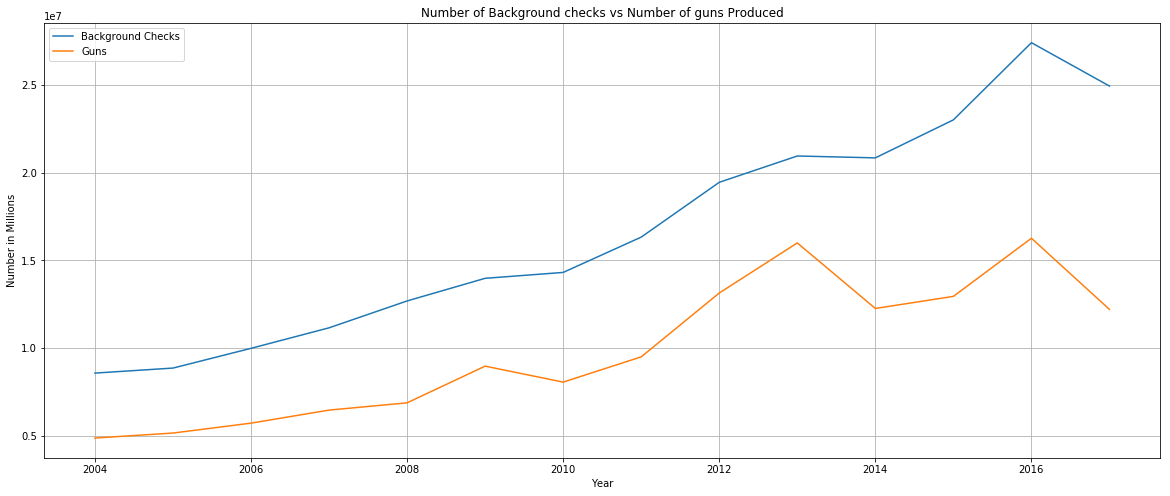

In [68]:
plt.plot(g_df["year"],g_df["all_total_bckgnd_chk"],label="Background Checks")
plt.plot(g_df["year"],g_df["total_guns_produced"],label="Guns")
plt.legend(loc="best")
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Number in Millions")
plt.title("Number of Background checks vs Number of guns Produced")
plt.savefig("./images/Num_bkgnd_vs_tot_guns_produced.png")

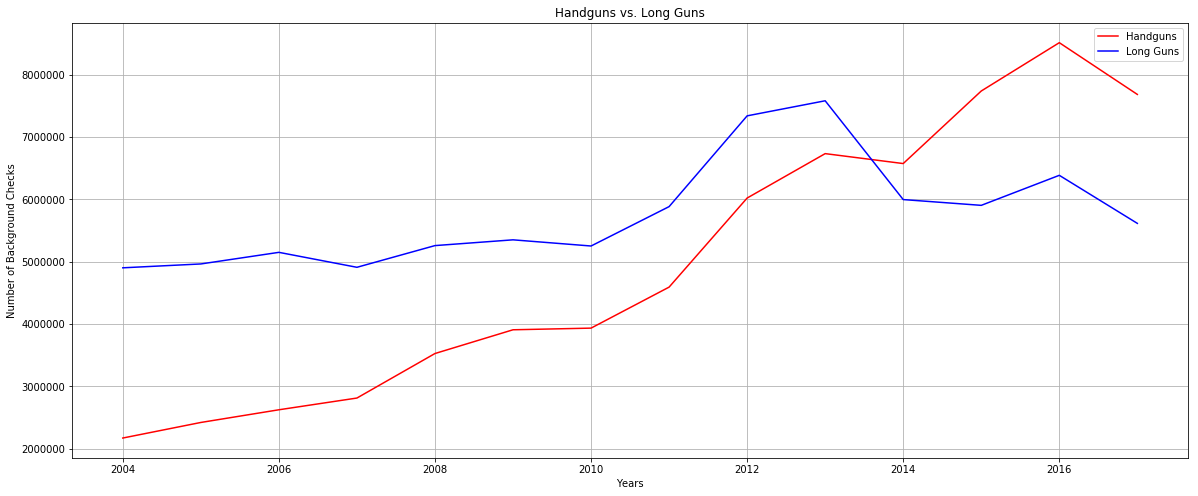

In [78]:
plt.plot(g_df["year"],g_df["total_handgun"],label="Handguns",c="red")
plt.plot(g_df["year"],g_df["total_long_gun"],label="Long Guns",c="blue")
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.grid()
plt.legend(loc="best")
plt.xlabel("Years")
plt.ylabel("Number of Background Checks")
plt.title("Handguns vs. Long Guns")
plt.savefig("./images/hand_vs_long.png")

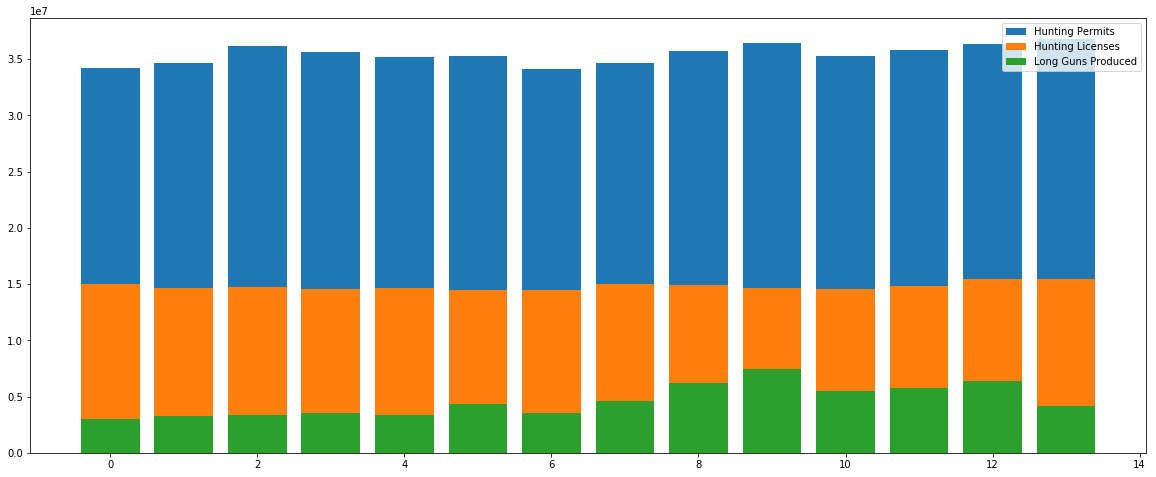

In [87]:
plt.bar(y_pos,g_df["hunt_permit_issued"],label="Hunting Permits")
plt.bar(y_pos,g_df["total_hunt_licences"],label="Hunting Licenses")#,bottom=g_df["hunt_permit_issued"])
plt.bar(y_pos,g_df["total_long_guns_us"],label="Long Guns Produced")
fig = plt.gcf()
fig.set_size_inches(20,8)
plt.legend(loc="best")